In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset

In [34]:
feature = pd.read_pickle("feature.pkl")
target = pd.read_pickle("target.pkl")

In [35]:
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.1, random_state=42, stratify=target)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.1, random_state=42, stratify=y_test)

In [36]:
x_train.shape, x_valid.shape, x_test.shape

((8100, 15000), (810, 15000), (90, 15000))

In [37]:
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)
x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [38]:
# 데이터셋 생성
import torch.utils.data.dataloader as dataloader
import torch.utils.data.dataset as dataset

class MyDataset(dataset.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [39]:
dataset_train = MyDataset(x_train, y_train)
dataset_test = MyDataset(x_test, y_test)
dataset_valid = MyDataset(x_valid, y_valid)

In [40]:
x_train.shape

torch.Size([8100, 15000])

In [41]:
class model(nn.Module): # 가중치 초기화 
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(15000, 4000)
        self.fc2 = nn.Linear(4000, 9)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [42]:
model2 = model()
for name, child in model2.named_children():
    nn.init.kaiming_normal_(child.weight)
optimizer = optim.Adagrad(model2.parameters())
criterion = nn.CrossEntropyLoss()

train_loader = dataloader.DataLoader(dataset_train, batch_size=100, shuffle=True, drop_last=True)
test_loader = dataloader.DataLoader(dataset_test, batch_size=100, shuffle=True, drop_last=True)
valid_loader = dataloader.DataLoader(dataset_valid, batch_size=100, shuffle=True, drop_last=True)

In [43]:
from torchmetrics.functional.classification import accuracy, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
model2.train()
valid_score=[]
train_score=[]

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

for epoch in range(15):
    
    for x,y in train_loader:
        output = model2(x)
        loss = criterion(output, y.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():        
        print(f"================================={epoch}=================================")
        output = model2(x_train)
        acc = accuracy(output, y_train.squeeze(), task="multiclass", num_classes=9, average="macro")
        f1 = f1_score(output, y_train.squeeze(), task="multiclass", num_classes=9, average="macro")
        train_score.append([acc, f1])
        print(f"train => acc : {acc}, f1 : {f1}")
        
        
        output = model2(x_valid)
        print(f"=================================valid score=================================")
        acc2 = accuracy(output, y_valid.squeeze(), task="multiclass", num_classes=9, average="macro")
        f12 = f1_score(output, y_valid.squeeze(), task="multiclass", num_classes=9, average="macro")
        valid_score.append([acc2, f12])
        print(f"valid => acc : {acc2}, f1 : {f12}")
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early stopping at epoch {epoch}")
        break


=================================0=================================


KeyboardInterrupt: 

In [ ]:
torch.save(model2,"./Adagrad_model.pth")

NameError: name 'model2' is not defined

In [ ]:
import torch
from torchmetrics.functional.classification import accuracy, f1_score
model2=model()
model2 = torch.load("./Adagrad_model.pth")

output = model2(x_test)
print(f"=================================test score=================================")
print(accuracy(output, y_test.squeeze(), task="multiclass", num_classes=9, average="macro"))
print(f1_score(output, y_test.squeeze(), task="multiclass", num_classes=9, average="macro"))

=================================test score=================================
tensor(0.7889)
tensor(0.7917)


In [49]:
train_acc = np.array(train_score)[:,0]
train_f1 = np.array(train_score)[:,1]

valid_acc = np.array(valid_score)[:,0]
valid_f1 = np.array(valid_score)[:,1]

In [46]:
train_score = [[0.5920, 0.5856],
  [0.7319, 0.7322],
  [0.7837, 0.7852],
  [0.8621, 0.8617],
  [0.8959, 0.8955],
  [0.9183, 0.9182],
  [0.9420, 0.9419],
  [0.9577, 0.9577],
  [0.9701, 0.9701],
  [0.9833, 0.9833],
  [0.9907, 0.9907],
  [0.9916, 0.9916],
  [0.9952, 0.9952],
  [0.9957, 0.9957],
  [0.9967, 0.9967]]
valid_score=[[0.5457, 0.5472],
  [0.6123, 0.6121],
  [0.6358, 0.6385],
  [0.6951, 0.6942],
  [0.7099, 0.7067],
  [0.7185, 0.7176],
  [0.7160, 0.7159],
  [0.7198, 0.7198],
  [0.7407, 0.7405],
  [0.7531, 0.7520],
  [0.7432, 0.7431],
  [0.7667, 0.7655],
  [0.7716, 0.7711],
  [0.7667, 0.7667],
  [0.7778, 0.7768]]

print(train_score)
print(valid_score)


[[0.592, 0.5856], [0.7319, 0.7322], [0.7837, 0.7852], [0.8621, 0.8617], [0.8959, 0.8955], [0.9183, 0.9182], [0.942, 0.9419], [0.9577, 0.9577], [0.9701, 0.9701], [0.9833, 0.9833], [0.9907, 0.9907], [0.9916, 0.9916], [0.9952, 0.9952], [0.9957, 0.9957], [0.9967, 0.9967]]
[[0.5457, 0.5472], [0.6123, 0.6121], [0.6358, 0.6385], [0.6951, 0.6942], [0.7099, 0.7067], [0.7185, 0.7176], [0.716, 0.7159], [0.7198, 0.7198], [0.7407, 0.7405], [0.7531, 0.752], [0.7432, 0.7431], [0.7667, 0.7655], [0.7716, 0.7711], [0.7667, 0.7667], [0.7778, 0.7768]]


In [47]:
train_score, valid_score

([[0.592, 0.5856],
  [0.7319, 0.7322],
  [0.7837, 0.7852],
  [0.8621, 0.8617],
  [0.8959, 0.8955],
  [0.9183, 0.9182],
  [0.942, 0.9419],
  [0.9577, 0.9577],
  [0.9701, 0.9701],
  [0.9833, 0.9833],
  [0.9907, 0.9907],
  [0.9916, 0.9916],
  [0.9952, 0.9952],
  [0.9957, 0.9957],
  [0.9967, 0.9967]],
 [[0.5457, 0.5472],
  [0.6123, 0.6121],
  [0.6358, 0.6385],
  [0.6951, 0.6942],
  [0.7099, 0.7067],
  [0.7185, 0.7176],
  [0.716, 0.7159],
  [0.7198, 0.7198],
  [0.7407, 0.7405],
  [0.7531, 0.752],
  [0.7432, 0.7431],
  [0.7667, 0.7655],
  [0.7716, 0.7711],
  [0.7667, 0.7667],
  [0.7778, 0.7768]])

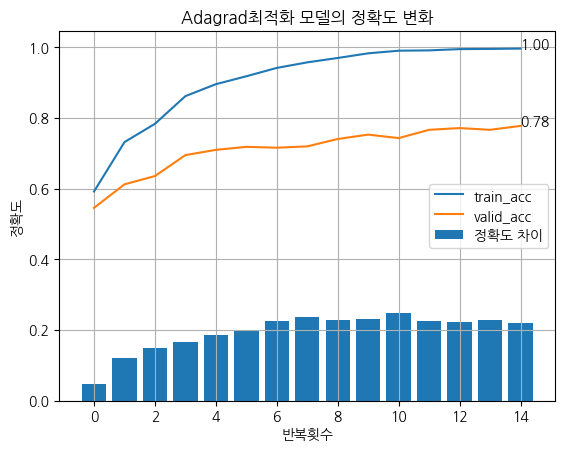

In [50]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot(train_acc, label="train_acc")
plt.plot(valid_acc, label="valid_acc")
plt.bar(range(15),train_acc-valid_acc, label="정확도 차이")
plt.legend()
plt.title("Adagrad최적화 모델의 정확도 변화")
plt.text(np.argmax(train_acc), np.max(train_acc), f"{np.max(train_acc):.2f}")
plt.text(np.argmax(valid_acc), np.max(valid_acc), f"{np.max(valid_acc):.2f}")
plt.xlabel("반복횟수")
plt.ylabel("정확도")
plt.grid()
plt.show()

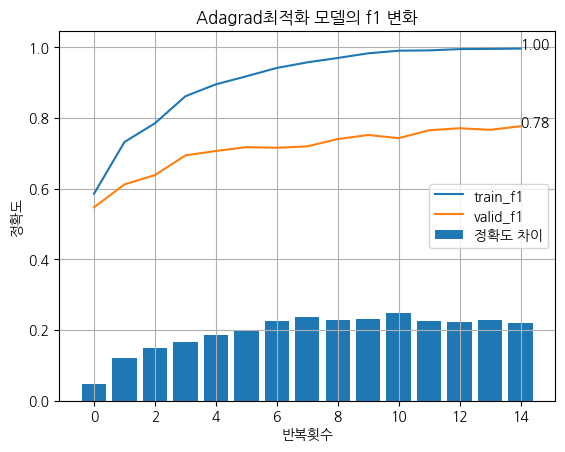

In [51]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot(train_f1, label="train_f1")
plt.plot(valid_f1, label="valid_f1")
plt.bar(range(15),train_acc-valid_acc, label="정확도 차이")
plt.legend()
plt.title("Adagrad최적화 모델의 f1 변화")
plt.xlabel("반복횟수")
plt.ylabel("정확도")
plt.text(np.argmax(train_f1), np.max(train_f1), f"{np.max(train_f1):.2f}")
plt.text(np.argmax(valid_f1), np.max(valid_f1), f"{np.max(valid_f1):.2f}")
plt.grid()
plt.show()

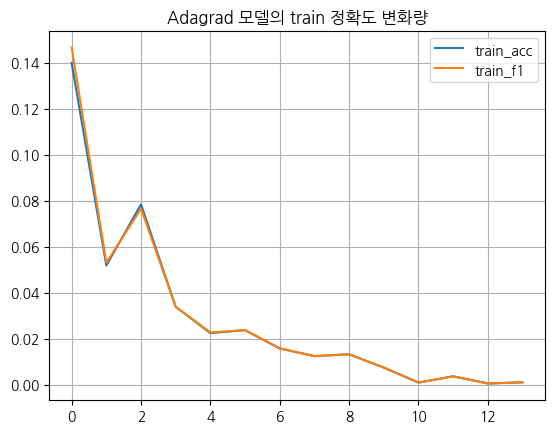

In [52]:
plt.plot(np.abs(train_acc[:-1]-train_acc[1:]), label="train_acc")
plt.plot(np.abs(train_f1[:-1]-train_f1[1:]), label="train_f1")
plt.title("Adagrad 모델의 train 정확도 변화량")
plt.legend()
plt.grid()
plt.show()

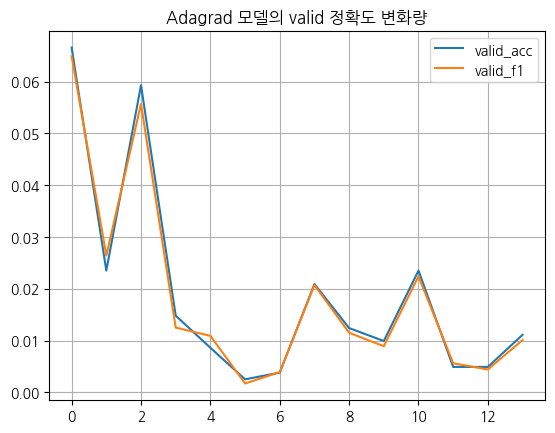

In [53]:
plt.plot(np.abs(valid_acc[:-1]-valid_acc[1:]), label="valid_acc")
plt.plot(np.abs(valid_f1[:-1]-valid_f1[1:]), label="valid_f1")
plt.title("Adagrad 모델의 valid 정확도 변화량")
plt.legend()
plt.grid()
plt.show()